In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [3]:
# 2. Đọc file dữ liệu GRAB và chia train test validate theo tỉ lệ 6-3-1
df = pd.read_csv('/content/drive/MyDrive/GRAB.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [5]:

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=47.670, Time=3.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=206.260, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=147.483, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=43.494, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=45.472, Time=0.39 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=45.468, Time=0.75 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=47.493, Time=0.57 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 6.415 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))


In [8]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted Opening prices for the next 30 days
print('Predicted Opening prices for the next 30 days:')
print(y_next_30_days)

Predicted Opening prices for the next 30 days:
[3.68853556 3.69707105 3.70560654 3.71414203 3.72267753 3.73121302
 3.73974851 3.748284   3.75681949 3.76535498 3.77389048 3.78242597
 3.79096146 3.79949695 3.80803244 3.81656793 3.82510343 3.83363892
 3.84217441 3.8507099  3.85924539 3.86778088 3.87631638 3.88485187
 3.89338736 3.90192285 3.91045834 3.91899383 3.92752933 3.93606482]


In [9]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 0.6896637990293694
Testing RMSE: 1.0858710761239312
Validation MAE: 0.637805198699699
Testing MAE: 1.05520202226509
Validation MAPE: 19.94388516595746
Testing MAPE: 32.58016862920674


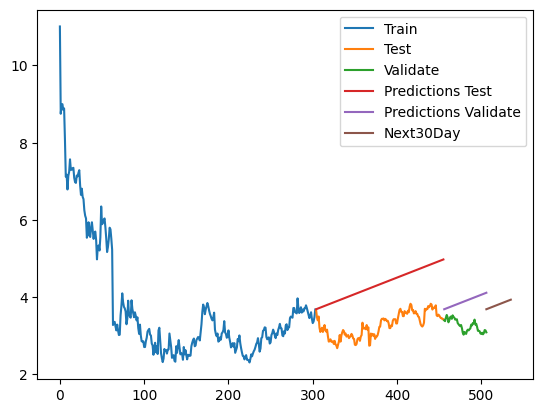

In [10]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate','Next30Day'])
plt.show()

In [11]:
test_data.index

RangeIndex(start=304, stop=456, step=1)